# Compare eddy structures from G4

LJK

Run on Cluster

Date created: 03/06/25

Last edited: 08/11/25

In [1]:
import json
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.lines import Line2D
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from datetime import datetime 

from config import *

In [2]:
fontsize = 18
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

### Sample Metadata

In [3]:
metadata_df = pd.read_csv(data_dir  + 'AVISO_eddies/AVISO_metadata_15km_near_eddy.csv',index_col=0)
metadata_df = metadata_df[12:] # sample 16 & later
metadata_df = metadata_df.set_index('sample_id')
metadata_df.head()

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc
sample_id,,,,,,,,
16,20211120,10:54,29.0000,236.5574,0,0,0,0
17,20211120,12:44,28.7390,236.1088,0,0,0,0
18,20211120,14:43,28.5030,235.7140,0,0,0,0
19,20211121,02:03,28.2847,235.3517,0,0,0,0
20,20211121,04:04,28.0397,234.9534,0,0,0,0


### Load Eddy Bounds

Original data downloaded from AVISO: https://www.aviso.altimetry.fr/en/data/products/value-added-products/global-mesoscale-eddy-trajectory-product/meta3-2-dt.html

Cropped the AVISO ds to only the G4 crossed eddies in script `G4_AVISO_eddies_v3.ipynb`

In [4]:
G4_cyc_ds = xr.open_dataset(data_dir + 'AVISO_eddies/META3.2_DT_allsat_Cyclonic_long_G4_crossings.nc')
G4_anti_ds = xr.open_dataset(data_dir + 'AVISO_eddies/META3.2_DT_allsat_Anticyclonic_long_G4_crossings.nc')
G4_anti_ds

<xarray.Dataset>
Dimensions:                        (NbSample: 20, obs: 148)
Dimensions without coordinates: NbSample, obs
Data variables:
    amplitude                      (obs) float32 ...
    cost_association               (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float32 ...
    effective_contour_longitude    (obs, NbSample) float32 ...
    effective_contour_shape_error  (obs) float32 ...
    effective_radius               (obs) float32 ...
    inner_contour_height           (obs) float32 ...
    latitude                       (obs) float32 ...
    latitude_max                   (obs) float32 ...
    longitude                      (obs) float32 ...
    longitude_max                  (obs) float32 ...
    num_contours                   (obs) uint16 ...
    num_point_e                    (obs) uint16 ...
    num_point_s                    (obs) uint16 ...
    observation_flag               (obs) int8 ...
    observation_number             (obs) uint16 ...
    speed_area                     (obs) float32 ...
    speed_average                  (obs) float32 ...
    speed_contour_height           (obs) float32 ...
    speed_contour_latitude         (obs, NbSample) float32 ...
    speed_contour_longitude        (obs, NbSample) float32 ...
    speed_contour_shape_error      (obs) float32 ...
    speed_radius                   (obs) float32 ...
    time                           (obs) datetime64[ns] ...
    track                          (obs) uint32 ...
    uavg_profile                   (obs, NbSample) float32 ...
Attributes:
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

Combine G4 cyc and anti dataset into one eddy ds

In [5]:
G4_eddy_ds = xr.concat([G4_cyc_ds,G4_anti_ds],dim='obs')

In [6]:
def get_eddy_by_date(eddy_id,eddy_date):
    """
    eddy_id: ID in G4_eddy_ds
    eddy_date: date in format 'YYYY-MM-DD'

    Returns: effective contour lons, 
             effective contour lats, 
             speed contour lons, 
             speed contour lats, 
             center lon, 
             center lat
             effective radius
    """
    try:
        ds = G4_eddy_ds.isel(obs=list(np.where(G4_eddy_ds.track==eddy_id)[0]))
        
        ind = np.where((ds.time == np.datetime64(eddy_date)))[0][0]
        eff_contour_lons = np.array(ds.effective_contour_longitude[ind])
        eff_contour_lats = np.array(ds.effective_contour_latitude[ind])
        spd_contour_lons = np.array(ds.speed_contour_longitude[ind])
        spd_contour_lats = np.array(ds.speed_contour_latitude[ind])
        eff_radius = np.array(ds.effective_radius[ind])
        
    except:
        print('No eddy data available with that request ... :(') 
    
    return eff_contour_lons,eff_contour_lats,spd_contour_lons,spd_contour_lats,ds.longitude[ind],ds.latitude[ind],eff_radius

### Spearman Dist Data

Calculated in `pcc_dist_by_physical_state_v2.ipynb` 

In [7]:
neighbor_df = pd.read_csv(data_dir + 'neighbor_metrics_v2.csv')
neighbor_df.head()

,Sample Pair,Latitude1,Latitude2,Middle Latitude,Eddy Code,all_phyto_STA_spearman,cyan_phyto_STA_spearman,euk_phyto_STA_spearman,phyto_groups_STA_spearman
0,16 - 17,29.0000,28.7390,28.86950,OO,0.885437,0.713158,0.935725,0.054545
1,17 - 18,28.7390,28.5030,28.62100,OO,0.994073,0.473395,0.854506,0.481818
2,18 - 19,28.5030,28.2847,28.39385,OO,0.794586,0.938201,0.706073,0.118182
3,19 - 20,28.2847,28.0397,28.16220,OO,0.865862,0.805035,0.882857,0.900000
4,20 - 21,28.0397,27.8012,27.92045,OY,0.968861,0.742214,0.965531,0.809091


In [8]:
mid_lats = neighbor_df['Latitude2'] + (np.subtract(neighbor_df['Latitude1'],neighbor_df['Latitude2'])/2)

### Eddy Structure Plot

Sorted by eddy age

In [9]:
# plot_ind:[eddy_name,eddy_id,day_to_plot]

eddy_dict = {0:['Shrutie',849094,'20211121'],
             1:['Josh',799833,'20211123'],
             2:['Cathy',847844,'20211125'],
             3:['Koko',845344,'20211126'],
             4:['Dean',844202,'20211122'],
             5:['Zinka',831329,'20211121'],
             6:['Sharon',823188,'20211123']}

In [10]:
def dimension_edges(dim_array):
    adjustment = float(dim_array[1]-dim_array[0])/2
    adjusted_array = [float(i)-adjustment for i in dim_array]
    adjusted_array.append(dim_array[-1]+adjustment)
    return np.array(adjusted_array)

In [11]:
def get_ftle_transect_bn_points(ftle,traj_lon_array,traj_lat_array,lon1,lat1,lon2,lat2,number_of_points):
    xs=np.linspace(lon1,lon2,number_of_points+2)
    ys=np.linspace(lat1,lat2,number_of_points+2)

    ftle_transect = []
    for i in range(len(xs)):
        ftle_transect.append(ftle[find_nearest(traj_lat_array,ys[i]),find_nearest(traj_lon_array,xs[i])])
        
    return ys,ftle_transect

In [12]:
def find_nearest(array, value):
    """
    Find nearest item in the array to the input value
    
    Input
        array: array to find the value in
        value: value of interest
    Output:
        idx: index of the value in the array
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

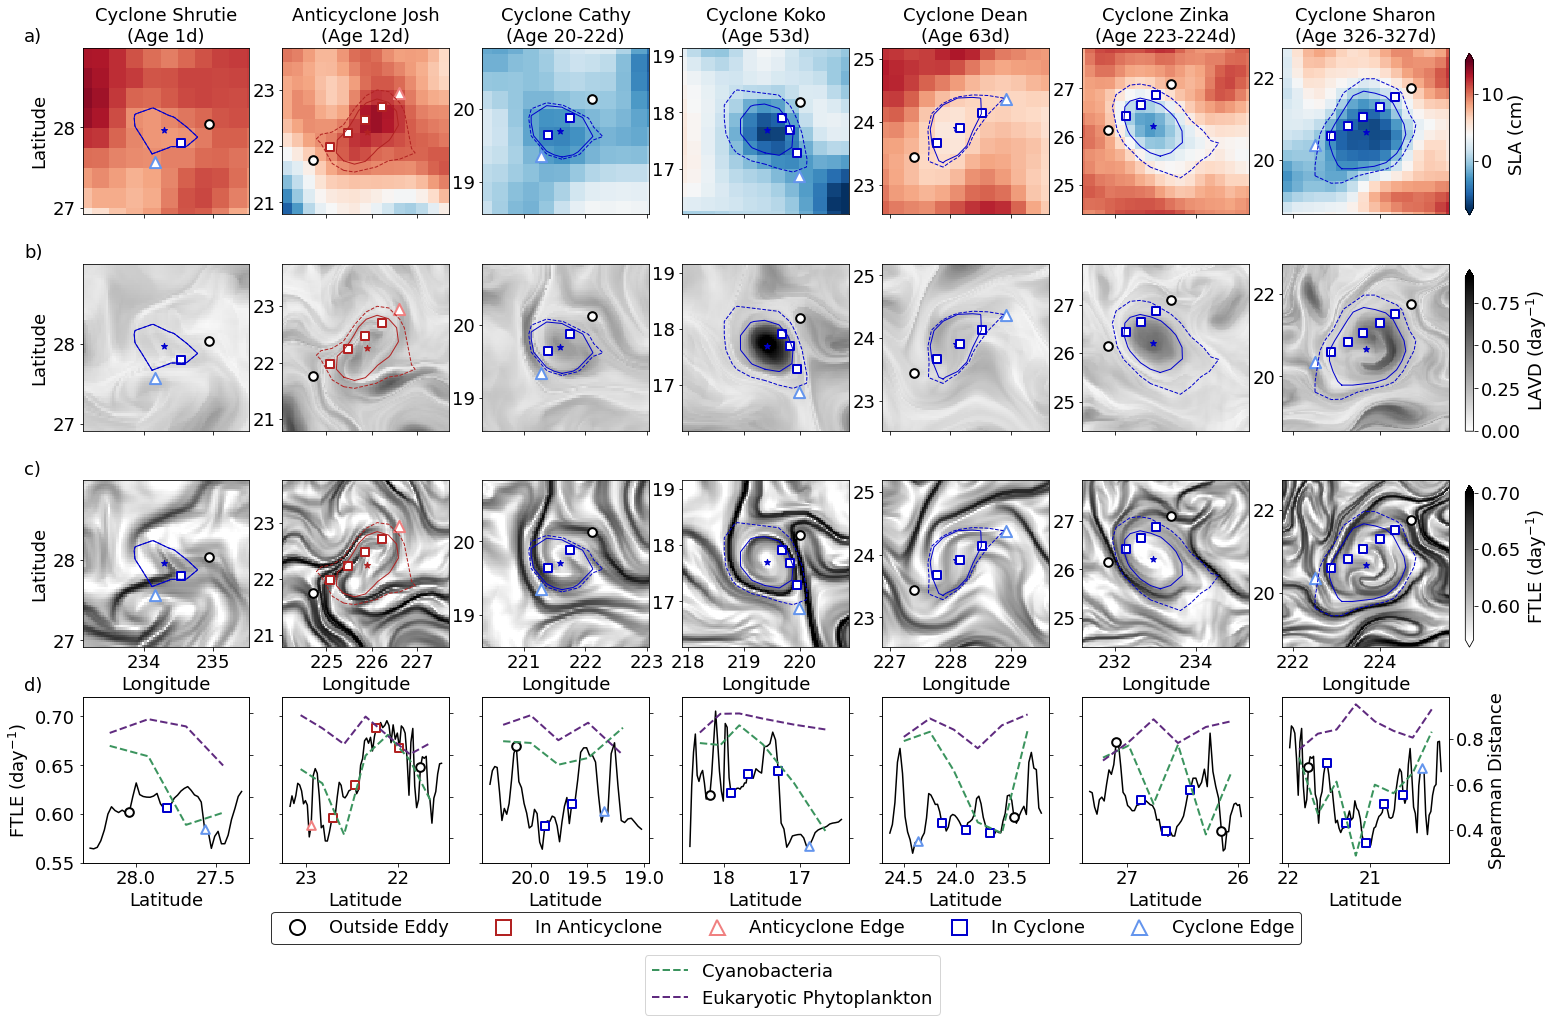

In [15]:
timescale = '28' # days

fig, ax = plt.subplots(4,7,figsize=(23,15))
plt.subplots_adjust(hspace=0.3)

cyan_color = '#3B945E'
euk_color = '#5F2A7F'

ax[0,0].set_title('Cyclone Shrutie\n(Age 1d)')
ax[0,1].set_title('Anticyclone Josh\n(Age 12d)')
ax[0,2].set_title('Cyclone Cathy\n(Age 20-22d)')
ax[0,3].set_title('Cyclone Koko\n(Age 53d)')
ax[0,4].set_title('Cyclone Dean\n(Age 63d)')
ax[0,5].set_title('Cyclone Zinka\n(Age 223-224d)')
ax[0,6].set_title('Cyclone Sharon\n(Age 326-327d)')

ftle_transect_dict = {}

# Iterate through each eddy
for col in range(7): # columns with map plots
    ax[2,col].set_xlabel('Longitude')
            
    # Get data for the current eddy
    eddy_name,eddy_id,eddy_date = eddy_dict[col] 
    eff_contour_lons,eff_contour_lats,spd_contour_lons,spd_contour_lats,center_lon,center_lat,radius = get_eddy_by_date(eddy_id,'%s-%s-%s'%(eddy_date[0:4],eddy_date[4:6],eddy_date[6:8]))
    metadata_inds = np.where(metadata_df['in_cyc'].eq(eddy_id) | metadata_df['in_anti'].eq(eddy_id))
    metadata_subset = metadata_df[metadata_inds[0][0]-1:metadata_inds[0][-1]+2] # get all points in the eddy plus two extra on either side
    
    ######## SLA PLOT ########
    CMEMS = xr.open_dataset(data_dir + 'CMEMS_data/dt_global_allsat_phy_l4_%s.nc'%(eddy_date)) 
    sla_plot = ax[0,col].pcolormesh(dimension_edges(CMEMS.longitude),dimension_edges(CMEMS.latitude),CMEMS.sla[0]*100,
                                    cmap='RdBu_r',vmin=-7,vmax=15,zorder=0)
    
    ######## LAVD PLOT ########
    lag_lat,lag_lon = np.arange(10,35,0.03125),np.arange(215,245,0.03125)
    LAVD = np.load(data_dir + 'LAVD/%s-%s-%s_%s_day_LAVD_20min_timestep_particle_start_lat_10.0_35.0_lon_215.0_245.0_spatial_step_0.03125_6hr_output_freq.npy'%(eddy_date[0:4],eddy_date[4:6],eddy_date[6:8],timescale))
    lavd_reshape = np.transpose(np.reshape(LAVD,(len(lag_lon),len(lag_lat))))*86400 # converting to day^-1
    lavd_plot = ax[1,col].pcolormesh(dimension_edges(lag_lon),dimension_edges(lag_lat),lavd_reshape,
                                     cmap='binary',vmin=0,vmax=0.9)

    ######## FTLE MAP ########
    FTLE = np.transpose(np.load(data_dir + 'FTLE/%s-%s-%s_%s_day_FTLE_20min_timestep_particle_start_lat_10.0_35.0_lon_215.0_245.0_spatial_step_0.03125_6hr_output_freq.npy'%(eddy_date[0:4],eddy_date[4:6],eddy_date[6:8],timescale)))
    ftle_plot = ax[2,col].pcolormesh(dimension_edges(lag_lon),dimension_edges(lag_lat),FTLE,
                                     cmap='binary',vmin=0.57,vmax=0.7,zorder=0) 
        
    ######## FTLE LINE PLOT ########
    if col != 0:
        ax[3,col].set_yticklabels([])
    ax[3,col].set_xlabel('Latitude')
    
    # Iterate through each sample to get the FLTE between sample sites
    ftle_transect_lats,ftle_transect = [],[]
    ftle_metadata_subset = metadata_df[metadata_inds[0][0]-2:metadata_inds[0][-1]+3] # get all points in the eddy plus two extra on either side
    for i in np.arange(0,len(ftle_metadata_subset)-1):
        lon1,lat1 = float(ftle_metadata_subset.iloc[i]['longitude']),float(ftle_metadata_subset.iloc[i]['latitude'])
        lon2,lat2 = float(ftle_metadata_subset.iloc[i+1]['longitude']),float(ftle_metadata_subset.iloc[i+1]['latitude'])
        lats,transect = get_ftle_transect_bn_points(FTLE,lag_lon,lag_lat,lon1,lat1,lon2,lat2,10)
        ftle_transect_lats.extend(lats)
        ftle_transect.extend(transect)
    ftle_transect_dict[eddy_name] = [ftle_transect_lats,ftle_transect]
    
    ax[3,col].plot(ftle_transect_lats,ftle_transect,c='k',zorder=0)
    #ax[3,col].set_ylim([0.73,0.95]) # limits for 21-day
    ax[3,col].set_ylim([0.55,0.72]) # limits for 28-day
    
    ax[3,col].invert_xaxis()
    
    ######## SPEARMAN LINE PLOTS ########
    axb = ax[3,col].twinx()
    
    # get inds to plot in neighbor df
    neighbor_inds = []
    neighbor_inds.append(int(neighbor_df.loc[neighbor_df['Sample Pair'].str.endswith(list(metadata_subset.index)[0], na=False)].index[0]))
    for i in list(metadata_subset.index):
        neighbor_inds.append(int(neighbor_df.loc[neighbor_df['Sample Pair'].str.startswith(i, na=False)].index[0]))
    
    axb.plot(mid_lats.iloc[neighbor_inds],neighbor_df['cyan_phyto_STA_spearman'].iloc[neighbor_inds],
             linestyle='--',linewidth=2,c=cyan_color,zorder=0,label='Cyanobacteria')
    axb.plot(mid_lats.iloc[neighbor_inds],neighbor_df['euk_phyto_STA_spearman'].iloc[neighbor_inds],
             linestyle='--',linewidth=2,c=euk_color,zorder=0,label='Eukaryotic Phytoplankton')

    if col != 6:
        axb.set_yticklabels([])
        axb.set_ylim([0.1,1.1]) 
            
    ######## PLOT SAMPLE LOCATIONS ########
    linewidth = 2
    scat_size = 75
    
    # FTLE samples
    for i in metadata_subset.index:
        x = metadata_subset.loc[i].latitude
        y = FTLE[find_nearest(lag_lat,metadata_subset.loc[i].latitude),find_nearest(lag_lon,metadata_subset.loc[i].longitude)]
        
        if metadata_subset.loc[i].in_anti != 0:
            edgecolor = 'firebrick'
            marker = 's'
        elif metadata_subset.loc[i].near_anti != 0:
            edgecolor = 'lightcoral'
            marker = '^'
        elif metadata_subset.loc[i].in_cyc != 0:
            edgecolor = 'mediumblue'
            marker = 's'
        elif metadata_subset.loc[i].near_cyc != 0:
            edgecolor = 'cornflowerblue'
            marker = '^'
        else:
            edgecolor = 'k'
            marker = 'o'
        
        ax[3,col].scatter(x,y,c='white',edgecolor=edgecolor,linewidth=linewidth,s=scat_size,marker=marker,zorder=10)
    
    # Map samples
    for row in range(3):
        # Plot eddy contours 
#        color = 'k'
        
        if eddy_name == 'Josh':
            color = 'firebrick'
        else:
            color = 'mediumblue'
        ax[row,col].plot(eff_contour_lons,eff_contour_lats,c=color,linewidth=1,linestyle='--')
        ax[row,col].plot(spd_contour_lons,spd_contour_lats,c=color,linewidth=1)
        ax[row,col].scatter(center_lon,center_lat,c=color,s=40,marker='*')
        
        # Plot sample locations
        ax[row,col].scatter([float(i) for i in metadata_subset[metadata_subset["in_anti"].ne(0)]["longitude"].tolist()],
                   [float(i) for i in metadata_subset[metadata_subset["in_anti"].ne(0)]["latitude"].tolist()],
                  c='white',edgecolor='firebrick',linewidth=linewidth,s=scat_size,marker='s',label='In Anticyclone')

        ax[row,col].scatter([float(i) for i in metadata_subset[metadata_subset["near_anti"].ne(0)]["longitude"].tolist()],
                   [float(i) for i in metadata_subset[metadata_subset["near_anti"].ne(0)]["latitude"].tolist()],
                  c='white',edgecolor='lightcoral',linewidth=linewidth,s=scat_size+50,marker='^',label='Anticyclone Edge')

        ax[row,col].scatter([float(i) for i in metadata_subset[metadata_subset["in_cyc"].ne(0)]["longitude"].tolist()],
                   [float(i) for i in metadata_subset[metadata_subset["in_cyc"].ne(0)]["latitude"].tolist()],
                  c='white',edgecolor='mediumblue',linewidth=linewidth,s=scat_size,marker='s',label='In Cyclone')

        ax[row,col].scatter([float(i) for i in metadata_subset[metadata_subset["near_cyc"].ne(0)]["longitude"].tolist()],
                   [float(i) for i in metadata_subset[metadata_subset["near_cyc"].ne(0)]["latitude"].tolist()],
                  c='white',edgecolor='cornflowerblue',linewidth=linewidth,s=scat_size+50,marker='^',label='Cyclone Edge')

        ax[row,col].scatter([float(i) for i in metadata_subset[metadata_subset["near_cyc"].eq(0) & metadata_subset["near_anti"].eq(0) & metadata_subset["in_cyc"].eq(0) & metadata_subset["in_anti"].eq(0)]["longitude"].tolist()],
                   [float(i) for i in metadata_subset[metadata_subset["near_cyc"].eq(0) & metadata_subset["near_anti"].eq(0) & metadata_subset["in_cyc"].eq(0) & metadata_subset["in_anti"].eq(0)]["latitude"].tolist()],
                    c='white',edgecolor='k',linewidth=linewidth,s=scat_size,label='Outside Eddy')
        
        
        # Set consistent bounds for each eddy
        buffer = 0.75
        ax[row,col].set_xlim([min(eff_contour_lons)-buffer,max(eff_contour_lons)+buffer])
        ax[row,col].set_ylim([min(eff_contour_lats)-buffer,max(eff_contour_lats)+buffer])
        
        
### COLORBARS ###
fig.subplots_adjust(right=0.95)

# SLA colorbar
cbar_ax0 = fig.add_axes([0.96, 0.725, 0.005, 0.15]) #[left,bottom,width,height]
fig.colorbar(sla_plot, extend='both', cax=cbar_ax0)
cbar_ax0.set_ylabel('SLA (cm)')

# LAVD colorbar    
cbar_ax1 = fig.add_axes([0.96, 0.525, 0.005, 0.15])
fig.colorbar(lavd_plot, extend='max', cax=cbar_ax1)
cbar_ax1.set_ylabel('LAVD (day$^{-1}$)')

# FTLE colorbar    
cbar_ax2 = fig.add_axes([0.96, 0.325, 0.005, 0.15])
fig.colorbar(ftle_plot, extend='both', cax=cbar_ax2)
cbar_ax2.set_ylabel('FTLE (day$^{-1}$)')

# Bottom row
axb.set_ylabel('Spearman Distance')
axb.legend(bbox_to_anchor=(-2,-0.5))
    
### OTHER PARAMS #### 
for row in range(3):
    ax[row,0].set_ylabel('Latitude')
    
    for col in range(7): # inds of main plots
        if row != 2:
            ax[row,col].set_xticklabels([]) # Turn off xticklabels for main plot
            
ax[3,0].set_ylabel('FTLE (day$^{-1}$)')

### Legend ###
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outside Eddy', markeredgecolor='k', markersize=15,markeredgewidth=2),
                  Line2D([0], [0], marker='s', color='w', label='In Anticyclone', markeredgecolor='firebrick', markersize=15,markeredgewidth=2),
                  Line2D([0], [0], marker='^', color='w', label='Anticyclone Edge', markeredgecolor='lightcoral', markersize=15,markeredgewidth=2),
                  Line2D([0], [0], marker='s', color='w', label='In Cyclone', markeredgecolor='mediumblue', markersize=15,markeredgewidth=2),
                  Line2D([0], [0], marker='^', color='w', label='Cyclone Edge', markeredgecolor='cornflowerblue', markersize=15,markeredgewidth=2)]

legend = plt.legend(handles=legend_elements,
    loc="lower center", # "upper center" puts it below the line
    ncol=5,
    bbox_to_anchor=(0.55, 0.05),
    borderaxespad=0,
    bbox_transform=fig.transFigure 
)
legend.legendPatch.set_edgecolor("k")

panel_labels = ['a)','b)','c)','d)']
for count in np.arange(0,4):
    ax[count,0].text(-0.35, 1.12, panel_labels[count],transform=ax[count,0].transAxes,va='top',ha='left')

# Saving as PDF not work, so saving as PNG
#plt.savefig(data_dir + 'G4_traj_paper_figs/eddy_structures_v2.png',bbox_inches='tight',pad_inches=0,dpi=350)
#plt.show()

### Get FTLE between all samples

FTLE-derived trajectories were initialized at 00:00 of the date they're titled. So should look for the midnight date that the sample collected is closest to.

In [16]:
date_strings = ['2021-11-19','2021-11-20','2021-11-21','2021-11-22','2021-11-23','2021-11-24','2021-11-25','2021-11-26','2021-11-27']
datetime_dict = {}
for d in date_strings:
    datetime_dict[d] = datetime(int(d[0:4]),int(d[5:7]),int(d[8:10]),0,0)
datetime_dict

{'2021-11-19': datetime.datetime(2021, 11, 19, 0, 0),
 '2021-11-20': datetime.datetime(2021, 11, 20, 0, 0),
 '2021-11-21': datetime.datetime(2021, 11, 21, 0, 0),
 '2021-11-22': datetime.datetime(2021, 11, 22, 0, 0),
 '2021-11-23': datetime.datetime(2021, 11, 23, 0, 0),
 '2021-11-24': datetime.datetime(2021, 11, 24, 0, 0),
 '2021-11-25': datetime.datetime(2021, 11, 25, 0, 0),
 '2021-11-26': datetime.datetime(2021, 11, 26, 0, 0),
 '2021-11-27': datetime.datetime(2021, 11, 27, 0, 0)}

In [17]:
# Iterate through each sample to get the FLTE between sample sites

ftle_bn_sites_dict = {} #sample - pair: [[flte_lats],[ftle]]

lag_lat,lag_lon = np.arange(10,35,0.03125),np.arange(215,245,0.03125)
for i in np.arange(0,len(metadata_df)-1):    
    sample1,sample2 = metadata_df.iloc[i], metadata_df.iloc[i+1]
    lon1,lat1 = float(sample1['longitude']),float(sample1['latitude'])
    lon2,lat2 = float(sample2['longitude']),float(sample2['latitude'])
    
    datetime1 = datetime(int(str(sample1['date'])[0:4]),int(str(sample1['date'])[4:6]),int(str(sample1['date'])[6:8]),
                         int(str(sample1['time_UTC'])[0:2]),int(str(sample1['time_UTC'])[3:5]))
    datetime2 = datetime(int(str(sample2['date'])[0:4]),int(str(sample2['date'])[4:6]),int(str(sample2['date'])[6:8]),
                         int(str(sample2['time_UTC'])[0:2]),int(str(sample2['time_UTC'])[3:5]))
    mid_sample_date = datetime1+(datetime2-datetime1) # the time in between the two samples 
    
    # Get the closest FTLE initialization date to the "mid date"
    closest_date = '2021-11-19' # start at the first 
    closest_time_diff = np.abs(datetime_dict[closest_date] - mid_sample_date)
    for key,values in datetime_dict.items():
        time_diff_to_check =  np.abs(values - mid_sample_date)
        if time_diff_to_check < closest_time_diff:
            closest_date,closest_time_diff = key,time_diff_to_check
    
    FTLE = np.transpose(np.load(data_dir + 'FTLE/%s_21_day_FTLE_20min_timestep_particle_start_lat_10.0_35.0_lon_215.0_245.0_spatial_step_0.03125_6hr_output_freq.npy'%(closest_date)))

    ftle_lats,ftle_transect = get_ftle_transect_bn_points(FTLE,lag_lon,lag_lat,lon1,lat1,lon2,lat2,10)
    ftle_bn_sites_dict['%s - %s'%(metadata_df.index[i],metadata_df.index[i+1])] = [list(ftle_lats),ftle_transect]

In [18]:
all_lats,all_ftle = [],[]
for key,values in ftle_bn_sites_dict.items():
    all_lats.extend(values[0])
    all_ftle.extend(values[1])

Save FTLE along transect at different time scales

In [19]:
lag_lat,lag_lon = np.arange(10,35,0.03125),np.arange(215,245,0.03125)

ftle_transects_by_time = []

time_lengths = [14,21,28,35,42,49,56,63]
for T in time_lengths:
    ftle_lats_all_sites,ftle_transect_all_sites = [],[]
    
    for i in np.arange(0,len(metadata_df)-1):    
        sample1,sample2 = metadata_df.iloc[i], metadata_df.iloc[i+1]
        lon1,lat1 = float(sample1['longitude']),float(sample1['latitude'])
        lon2,lat2 = float(sample2['longitude']),float(sample2['latitude'])

        datetime1 = datetime(int(str(sample1['date'])[0:4]),int(str(sample1['date'])[4:6]),int(str(sample1['date'])[6:8]),
                             int(str(sample1['time_UTC'])[0:2]),int(str(sample1['time_UTC'])[3:5]))
        datetime2 = datetime(int(str(sample2['date'])[0:4]),int(str(sample2['date'])[4:6]),int(str(sample2['date'])[6:8]),
                             int(str(sample2['time_UTC'])[0:2]),int(str(sample2['time_UTC'])[3:5]))
        mid_sample_date = datetime1+(datetime2-datetime1) # the time in between the two samples 

        # Get the closest FTLE initialization date to the "mid date"
        closest_date = '2021-11-19' # start at the first 
        closest_time_diff = np.abs(datetime_dict[closest_date] - mid_sample_date)
        for key,values in datetime_dict.items():
            time_diff_to_check =  np.abs(values - mid_sample_date)
            if time_diff_to_check < closest_time_diff:
                closest_date,closest_time_diff = key,time_diff_to_check

        FTLE = np.transpose(np.load(data_dir + 'FTLE/%s_%s_day_FTLE_20min_timestep_particle_start_lat_10.0_35.0_lon_215.0_245.0_spatial_step_0.03125_6hr_output_freq.npy'%(closest_date,T)))

        ftle_lats,ftle_transect = get_ftle_transect_bn_points(FTLE,lag_lon,lag_lat,lon1,lat1,lon2,lat2,10)
        ftle_lats_all_sites.extend(ftle_lats)
        ftle_transect_all_sites.extend(ftle_transect)
    ftle_transects_by_time.append(ftle_transect_all_sites)

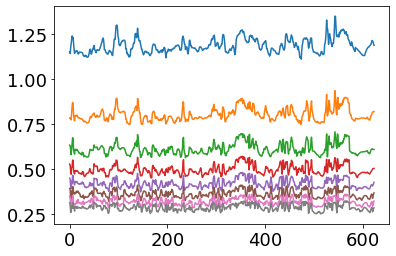

In [20]:
for i in ftle_transects_by_time:
    plt.plot(i)

In [21]:
ftle_df = pd.DataFrame(np.transpose(ftle_transects_by_time),columns=time_lengths, index=ftle_lats_all_sites)
ftle_df

,14,21,28,35,42,49,56,63
29.000000,1.148689,0.780960,0.631279,0.525629,0.447674,0.390197,0.346628,0.311229
28.976273,1.140441,0.783595,0.628088,0.519865,0.442923,0.386186,0.341512,0.305753
28.952545,1.169941,0.780987,0.606036,0.488084,0.403060,0.332880,0.285232,0.258664
28.928818,1.192393,0.771671,0.577953,0.469494,0.390780,0.336553,0.293164,0.258026
28.905091,1.211708,0.813317,0.612931,0.507533,0.430558,0.375043,0.328745,0.290961
...,...,...,...,...,...,...,...,...
15.769491,1.212691,0.807015,0.610726,0.492437,0.408629,0.356299,0.317344,0.285409
15.731418,1.209265,0.814231,0.607563,0.498322,0.403845,0.335293,0.292781,0.260630
15.693345,1.203650,0.816458,0.607471,0.500338,0.411432,0.349237,0.296751,0.268210
15.655273,1.194596,0.818086,0.607180,0.501109,0.418571,0.359709,0.311295,0.278630


In [22]:
#ftle_df.to_csv(data_dir + 'FTLE/FTLE_bn_G4_samples_by_timescale.csv')

### FTLE Tile Plot

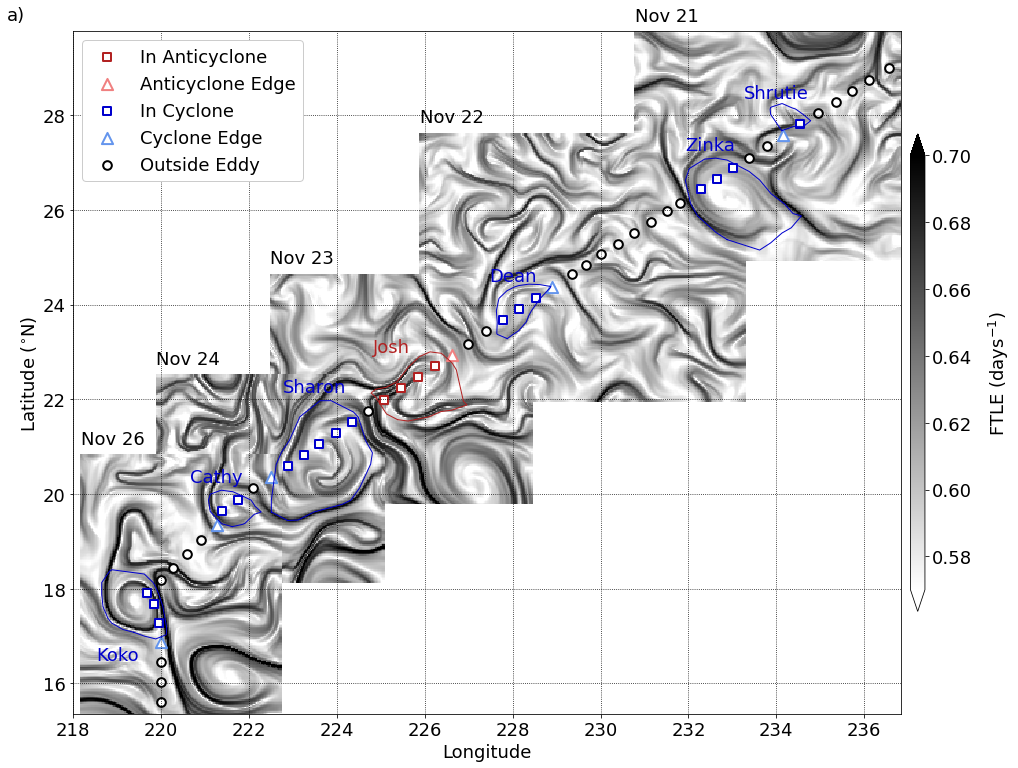

In [26]:
timescale = 28

fig,ax = plt.subplots(1,1,figsize=(15,11)) # horizontal, vertical

traj_lat_array = np.arange(10,35,0.03125)
traj_lon_array = np.arange(215,245,0.03125)

for d in np.unique(metadata_df['date']):
    date_specific_metadata = metadata_df[metadata_df['date'] == d]
    lats = list(date_specific_metadata['latitude'])
    lons = list(date_specific_metadata['longitude'])
    
    ftle = np.transpose(np.load(data_dir + 
        'FTLE/%s-%s-%s_%s_day_FTLE_20min_timestep_particle_start_lat_10.0_35.0_lon_215.0_245.0_spatial_step_0.03125_6hr_output_freq.npy'%(str(d)[0:4],str(d)[4:6],str(d)[6:8],timescale)))

    buffer = 1.5
    lon_min,lon_max = min(lons)-buffer,max(lons)+buffer
    lat_min,lat_max = min(lats)-buffer,max(lats)+buffer
    lon_inds = np.where((traj_lon_array >= lon_min) & (traj_lon_array <= lon_max))[0]
    lat_inds = np.where((traj_lat_array >= lat_min) & (traj_lat_array <= lat_max))[0]
    
    ############################ PLOT EDDIES ############################

    try:
        anti_tracks = G4_AVISO_anti_dict[d]
        for a in anti_tracks:
            for index, row in anti_df.iterrows():
                if (row['Eddy ID'] == a) & (row['Date'] == d):  
                    contour_lons = row['Contour Lons']
                    contour_lats = row['Contour Lats']
    
                    # Ensure they are lists
                    if isinstance(contour_lons, str):
                        contour_lons = ast.literal_eval(contour_lons)
                    if isinstance(contour_lats, str):
                        contour_lats = ast.literal_eval(contour_lats)
                    ax.plot(contour_lons,contour_lats,c='k',label='Eddy Boundary')
    except:
        pass

    try:
        cyc_tracks = G4_AVISO_cyc_dict[d]
        for a in cyc_tracks:
            for index, row in cyc_df.iterrows():
                if (row['Eddy ID'] == a) & (row['Date'] == d):  
                    contour_lons = row['Contour Lons']
                    contour_lats = row['Contour Lats']
    
                    # Ensure they are lists
                    if isinstance(contour_lons, str):
                        contour_lons = ast.literal_eval(contour_lons)
                    if isinstance(contour_lats, str):
                        contour_lats = ast.literal_eval(contour_lats)
                    ax.plot(contour_lons,contour_lats,c='k')
    except:
        pass
            
    if (str(d) != '20211120') & (str(d) != '20211127'): # for plot simplicity, don't show first and last day
        #Plot the date
        ax.text(min(lons)-buffer,max(lats)+buffer+0.2,'Nov %s'%(str(d)[6:8]),fontsize=fontsize,color='k')
        ftle_plot = ax.pcolormesh(traj_lon_array[lon_inds[0]:lon_inds[-1]],
                              traj_lat_array[lat_inds[0]:lat_inds[-1]],
                            ftle[lat_inds[0]:lat_inds[-1],lon_inds[0]:lon_inds[-1]],
                            zorder=0,shading='nearest',cmap='binary',vmin=0.57,vmax=0.7)

linewidth = 2
scat_size = 75
ax.scatter([float(i) for i in metadata_df[metadata_df["in_anti"].ne(0)]["longitude"].tolist()],
           [float(i) for i in metadata_df[metadata_df["in_anti"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='firebrick',linewidth=linewidth,s=scat_size,marker='s',label='In Anticyclone')

ax.scatter([float(i) for i in metadata_df[metadata_df["near_anti"].ne(0)]["longitude"].tolist()],
           [float(i) for i in metadata_df[metadata_df["near_anti"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='lightcoral',linewidth=linewidth,s=scat_size+50,marker='^',label='Anticyclone Edge')

ax.scatter([float(i) for i in metadata_df[metadata_df["in_cyc"].ne(0)]["longitude"].tolist()],
           [float(i) for i in metadata_df[metadata_df["in_cyc"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='mediumblue',linewidth=linewidth,s=scat_size,marker='s',label='In Cyclone')

ax.scatter([float(i) for i in metadata_df[metadata_df["near_cyc"].ne(0)]["longitude"].tolist()],
           [float(i) for i in metadata_df[metadata_df["near_cyc"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='cornflowerblue',linewidth=linewidth,s=scat_size+50,marker='^',label='Cyclone Edge')

ax.scatter([float(i) for i in metadata_df[metadata_df["near_cyc"].eq(0) & metadata_df["near_anti"].eq(0) & metadata_df["in_cyc"].eq(0) & metadata_df["in_anti"].eq(0)]["longitude"].tolist()],
           [float(i) for i in metadata_df[metadata_df["near_cyc"].eq(0) & metadata_df["near_anti"].eq(0) & metadata_df["in_cyc"].eq(0) & metadata_df["in_anti"].eq(0)]["latitude"].tolist()],
            c='white',edgecolor='k',linewidth=linewidth,s=scat_size,marker='o',label='Outside Eddy')

#Colorbar
cbar = plt.colorbar(ftle_plot,ax=ax,extend='both',pad=0.01,aspect=30,shrink=0.7)
cbar.set_label('FTLE (days$^{-1}$)',labelpad=15)

# Get data for the current eddy
for ed in eddy_dict:
    eddy_name,eddy_id,eddy_date = eddy_dict[ed] 
    eff_contour_lons,eff_contour_lats,spd_contour_lons,spd_contour_lats,center_lon,center_lat,radius = get_eddy_by_date(eddy_id,'%s-%s-%s'%(eddy_date[0:4],eddy_date[4:6],eddy_date[6:8]))
    if eddy_name != 'Josh':
        color = 'mediumblue'
    else:
        color = 'firebrick'
    ax.plot(eff_contour_lons,eff_contour_lats,c=color,linewidth=1)


# Plot eddy names
ax.text(234,28.35,'Shrutie',horizontalalignment='center',color='mediumblue')
ax.text(232.5,27.25,'Zinka',horizontalalignment='center',color='mediumblue')
ax.text(228,24.5,'Dean',horizontalalignment='center',color='mediumblue')
ax.text(225.25,23,'Josh',horizontalalignment='center',color='firebrick')
ax.text(223.5,22.15,'Sharon',horizontalalignment='center',color='mediumblue')
ax.text(221.25,20.25,'Cathy',horizontalalignment='center',color='mediumblue')
ax.text(219,16.5,'Koko',horizontalalignment='center',color='mediumblue')

#Figure params
ax.set_xticks(np.arange(218,238,2))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude ($^{\circ}}$N)')
plt.grid(zorder=0,c='k',linestyle=':')
plt.legend(loc='upper left',framealpha=1)

#ax.text(216.5,30,'a)')


plt.tight_layout()

#plt.savefig(data_dir + 'G4_traj_paper_figs/FTLE_tile_plot_with_sample_locations.pdf',bbox_inches='tight',pad_inches=0,dpi=350,format='pdf')